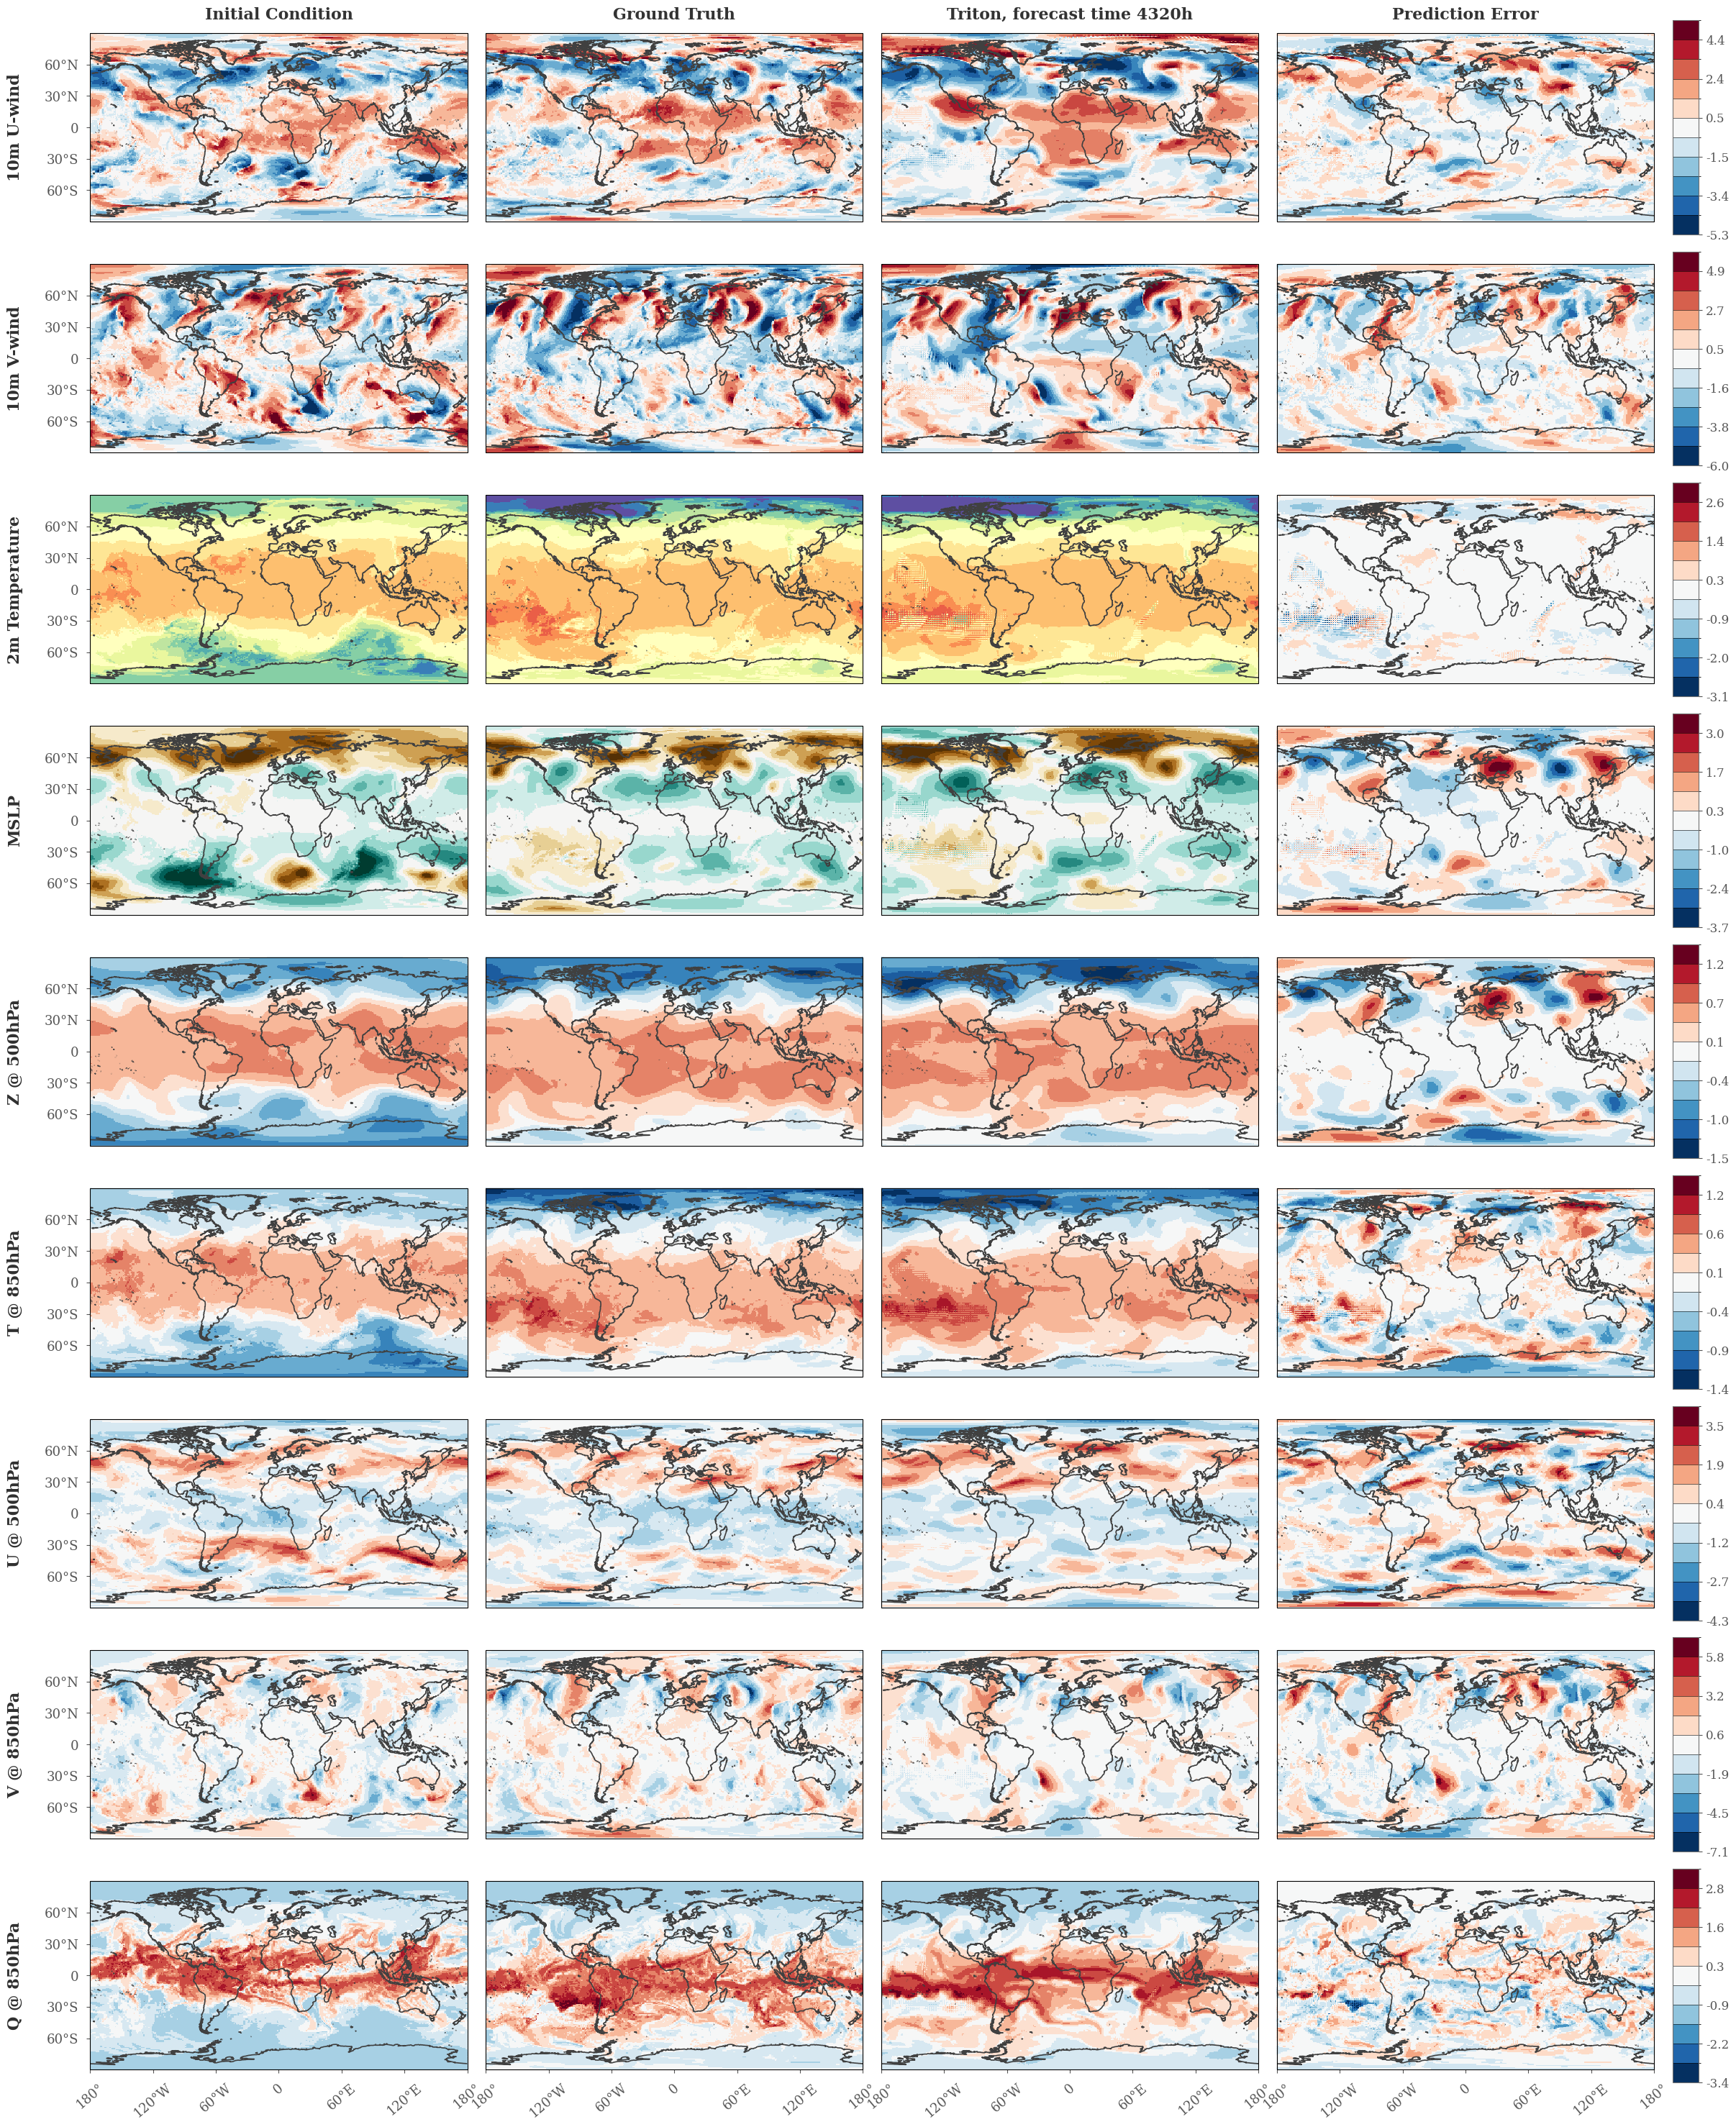

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams['mathtext.fontset'] = 'stix'

path = '/Users/wuhao/Desktop/Triton_sub_exp/S1_weather_forecasting/2020_triton_results'
day_index = 179
hours_index = ( day_index + 1 ) * 24

backbone = 'baselines_triton_20250326_exp1'

initial_condition = np.load(f'{path}/{backbone}_initial_input.npy')
ground_truth = np.load(f'{path}/{backbone}_true_label_step_{day_index}.npy')
prediction = np.load(f'{path}/{backbone}_prediction_step_{day_index}.npy')

#  (13 levels from top to surface)
pressure_levels = [50, 100, 150, 200, 250, 300, 400, 
                   500, 600, 700, 850, 925, 1000]  # hPa

def get_var_index(base, level_idx):
    """Calculate variable indices base
    base: 0(U),1(V),2(T),3(Z),4(Q)
    level_idx: 0-corresponds to pressure layer indices
    """
    return 4 + base*13 + level_idx

# ===  Variable Configuration  ===
surface_vars = {
    'indices': [0, 1, 2, 3],  # The first four are surface variables.
    'labels': ['10m U-wind', '10m V-wind', '2m Temperature', 'MSLP'],
    'cmaps': ['RdBu', 'RdBu', 'Spectral_r', 'BrBG'],
    'clim': (-3, 3)
}

upper_air_vars = {
    'indices': [
        get_var_index(3, 7),   # Z500
        get_var_index(2, 10),  # T850
        get_var_index(0, 7),   # U500
        get_var_index(1, 10),  # V850
        get_var_index(4, 10)   # Q850 
    ],
    'labels': [
        r'Z @ 500hPa',
        r'T @ 850hPa',
        r'U @ 500hPa',
        r'V @ 850hPa',
        r'Q @ 850hPa'  
    ],
    'cmaps': ['RdBu_r', 'RdBu_r', 'RdBu_r', 'RdBu_r', 'RdBu_r'], 
    'clim': (None, None)
}

lon = np.linspace(-180, 180, 360)
lat = np.linspace(-90, 90, 180)
COASTLINE_STYLE = dict(linewidth=1.2, edgecolor='#404040')
error_cmap = 'RdBu_r'

def create_plot_panel(vars_config, total_rows=9):  
    fig = plt.figure(figsize=(26, total_rows*3.5), dpi=100)
    gs = fig.add_gridspec(total_rows, 5, 
                         width_ratios=[1, 1, 1, 1, 0.07],
                         hspace=0.08, wspace=0.06)

    row_counter = 0
    
    for var_type in [surface_vars, upper_air_vars]:
        for i in range(len(var_type['indices'])):  
            var_idx = var_type['indices'][i]
            data_initial = initial_condition[var_idx]
            data_true = ground_truth[var_idx]
            data_pred = prediction[var_idx]
            error = data_pred - data_true

            data_pool = np.concatenate([data_initial.flatten(), 
                                      data_true.flatten(), 
                                      data_pred.flatten()])
            
            if var_type['clim'][0] is None:
                abs_max = np.max(np.abs(data_pool))
                vmin, vmax = -abs_max, abs_max
            else:
                vmin, vmax = var_type['clim']
            
            levels = 13
            bounds = np.linspace(vmin, vmax, levels+1)
            norm = BoundaryNorm(bounds, ncolors=256)
            
            err_absmax = np.max(np.abs(error))
            err_levels = 11
            err_bounds = np.linspace(-err_absmax, err_absmax, err_levels+1)
            err_norm = BoundaryNorm(err_bounds, ncolors=256)

            for col in range(4):
                ax = fig.add_subplot(gs[row_counter, col], projection=ccrs.PlateCarree())
                
                if col == 0:
                    data = data_initial
                    cmap = var_type['cmaps'][i]
                    cnorm = norm
                elif col == 1:
                    data = data_true
                    cmap = var_type['cmaps'][i]
                    cnorm = norm
                elif col == 2:
                    data = data_pred
                    cmap = var_type['cmaps'][i]
                    cnorm = norm
                else:
                    data = error
                    cmap = error_cmap
                    cnorm = err_norm

                mesh = ax.pcolormesh(lon, lat, data, 
                                    cmap=cmap, norm=cnorm,
                                    transform=ccrs.PlateCarree())
                
                ax.add_feature(cfeature.COASTLINE.with_scale('50m'), **COASTLINE_STYLE)

                if row_counter == total_rows-1:
                    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
                    ax.xaxis.set_major_formatter(plt.FixedFormatter(['180°','120°W','60°W','0','60°E','120°E','180°']))
                    ax.tick_params(axis='x', labelsize=13, rotation=40, pad=8, colors='#555555')
                else:
                    ax.set_xticks([])
                
                if col == 0:
                    ax.set_yticks(np.arange(-60, 61, 30), crs=ccrs.PlateCarree())
                    ax.yaxis.set_major_formatter(plt.FixedFormatter(['60°S','30°S','0','30°N','60°N']))
                    ax.tick_params(axis='y', labelsize=13, pad=8, colors='#555555')
                else:
                    ax.set_yticks([])

            cax = fig.add_subplot(gs[row_counter, 4])
            cbar = plt.colorbar(mesh, cax=cax, 
                              ticks=bounds[::2] if col !=3 else err_bounds[::2],
                              format='%.1f', 
                              drawedges=True,
                              extendfrac='auto')
            cbar.ax.tick_params(labelsize=12, colors='#555555')
            cbar.outline.set_edgecolor('#707070')

            label_ax = fig.axes[5*row_counter]
            label_ax.annotate(var_type['labels'][i], 
                            xy=(-0.22, 0.5), 
                            xycoords='axes fraction',
                            rotation=90, va='center', 
                            fontsize=16,
                            fontweight='bold',
                            color='#2F2F2F')
            
            row_counter += 1

    col_titles = ['Initial Condition', 'Ground Truth', 
                 f'Triton, forecast time {hours_index}h', 'Prediction Error']
    for idx, title in enumerate(col_titles):
        fig.axes[idx].set_title(title, fontsize=16, pad=14,
                              fontweight='bold', color='#333333')

    plt.subplots_adjust(left=0.07, right=0.93, top=0.96, bottom=0.05)
    return fig

fig = create_plot_panel(surface_vars, total_rows=9)
plt.savefig(f'weather_analysis_{hours_index}h.png', dpi=100, 
           bbox_inches='tight', facecolor='white')
plt.show()